# Présentation du travail pour le datachallenge
Víctor Camps, Aldric Bahna

## Exploration des données

Import des bibliothèques utiles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings

In [2]:
# Activer le rechargement automatique des modules
%load_ext autoreload
%autoreload 2

Chemin vers les données

In [3]:
data_dir = Path('data')
x_train_dir = data_dir / 'x_train_images'
x_test_dir = data_dir / 'x_test_images'
y_train_file = data_dir / 'y_train_labels' / 'Y_train_T9NrBYo.csv'

In [4]:
# Charger les labels d'entraînement depuis le CSV
print("Chargement des labels d'entraînement...")
y_train = pd.read_csv(y_train_file, index_col=0)
print(f"Chargés {len(y_train)} patches d'entraînement")
print(f"\nFormes du dataset: {y_train.shape}")
print(f"Exemples de noms de patches: {list(y_train.index[:5])}")
print(f"\nPremières valeurs du premier patch:")
print(y_train.iloc[0, :20])

Chargement des labels d'entraînement...
Chargés 4410 patches d'entraînement

Formes du dataset: (4410, 43520)
Exemples de noms de patches: ['well_2_section_22_patch_1', 'well_6_section_10_patch_3', 'well_1_section_10_patch_6', 'well_6_section_10_patch_15', 'well_1_section_14_patch_6']

Premières valeurs du premier patch:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    2
19    2
Name: well_2_section_22_patch_1, dtype: int64


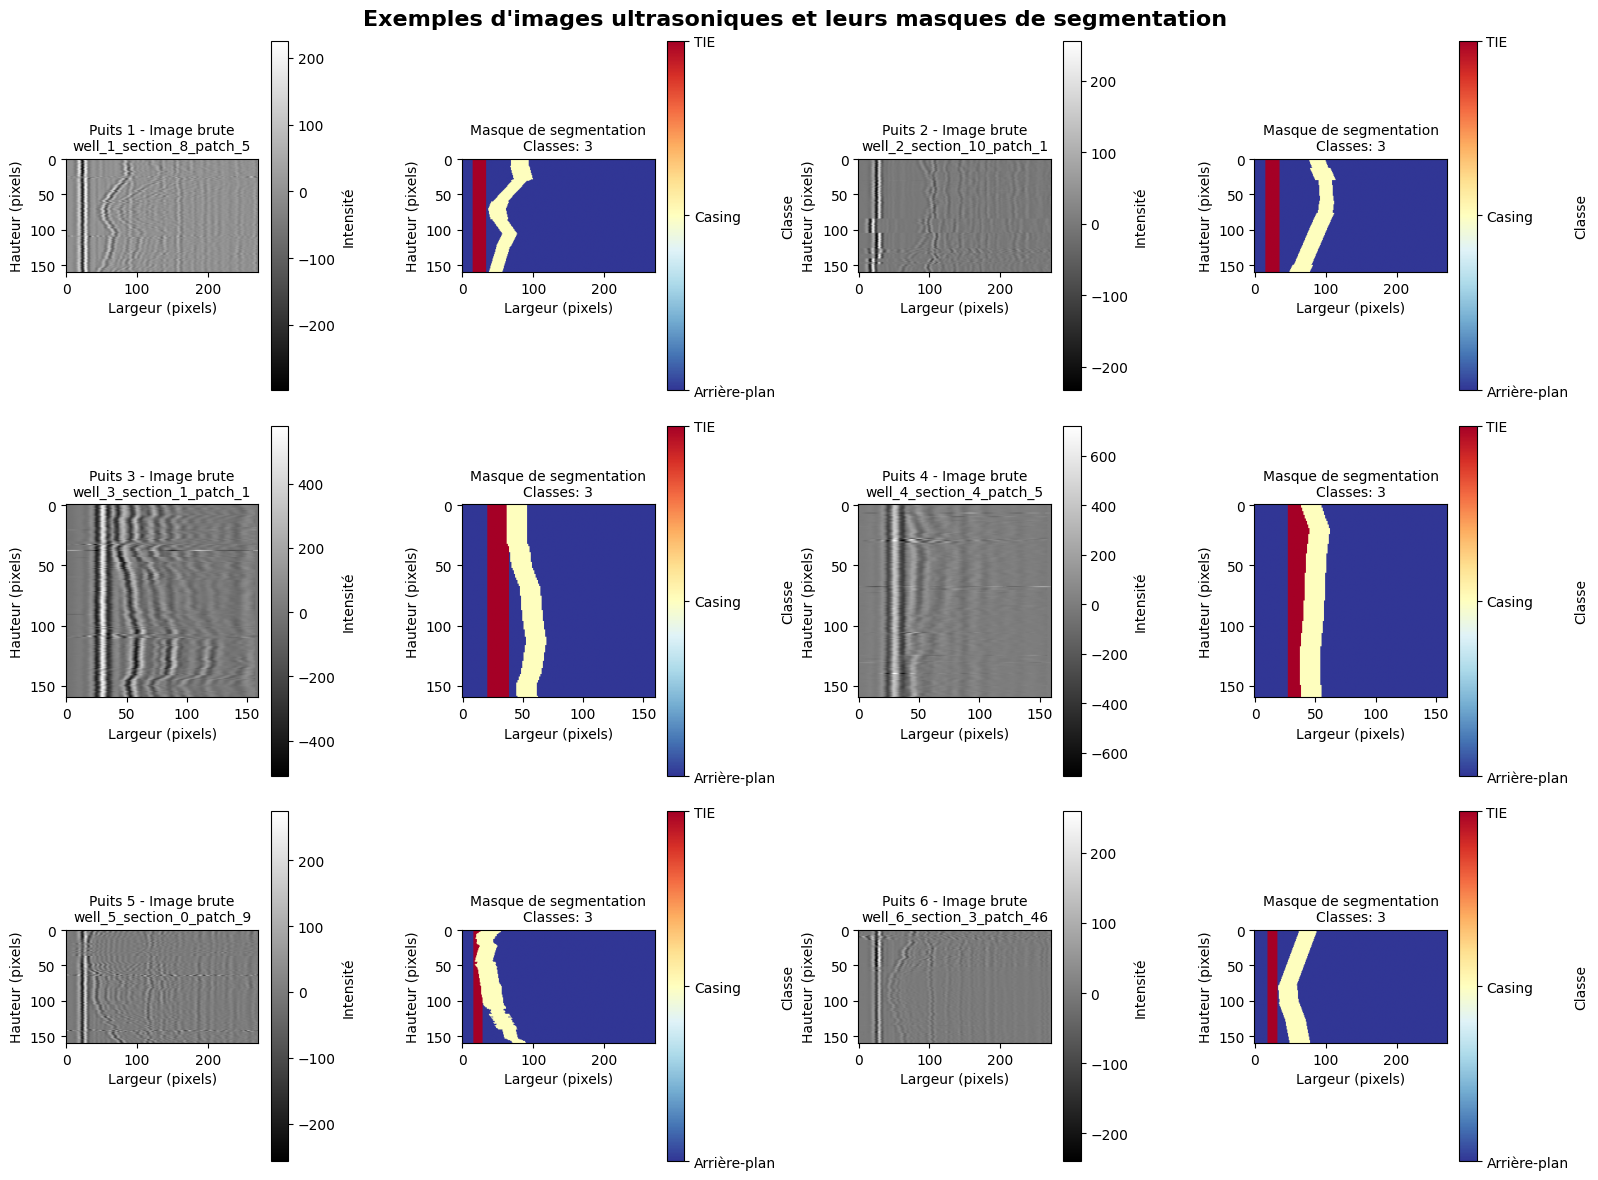

In [5]:
# Visualiser des échantillons de différents puits
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Exemples d\'images ultrasoniques et leurs masques de segmentation', fontsize=16, fontweight='bold')

well_samples = ['1', '2', '3', '4', '5', '6']
sample_count = 0

for well in well_samples:
    # Récupérer les patches de ce puits
    well_patches = [p for p in y_train.index if f'well_{well}_' in p]
    
    if well_patches and sample_count < 6:
        # Échantillonner le patch du milieu du puits
        sample_idx = len(well_patches) // 2
        patch_name = well_patches[sample_idx]
        
        # Charger l'image
        image_path = x_train_dir / f"{patch_name}.npy"
        image = np.load(image_path)
        
        # Charger le label
        label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
        label = label_values.reshape(160, -1)
        
        # Tracer l'image
        row = sample_count // 2
        col = (sample_count % 2) * 2
        
        if row < 3:
            # Image brute
            ax1 = axes[row, col]
            im1 = ax1.imshow(image, cmap='gray')
            ax1.set_title(f'Puits {well} - Image brute\n{patch_name}', fontsize=10)
            ax1.set_xlabel('Largeur (pixels)')
            ax1.set_ylabel('Hauteur (pixels)')
            plt.colorbar(im1, ax=ax1, label='Intensité')
            
            # Masque de segmentation
            ax2 = axes[row, col+1]
            im2 = ax2.imshow(label, cmap='RdYlBu_r', vmin=0, vmax=2)
            ax2.set_title(f'Masque de segmentation\nClasses: {len(np.unique(label))}', fontsize=10)
            ax2.set_xlabel('Largeur (pixels)')
            ax2.set_ylabel('Hauteur (pixels)')
            cbar = plt.colorbar(im2, ax=ax2, label='Classe')
            cbar.set_ticks([0, 1, 2])
            cbar.set_ticklabels(['Arrière-plan', 'Casing', 'TIE'])
            
            sample_count += 1

plt.tight_layout()
plt.show()

## Structure des données et dimensions

In [6]:
# Extraire les informations de puits et de section à partir des noms de patches
wells_info = {}

for patch_name in y_train.index:
    parts = patch_name.split('_')

On remarque que l'on a beaucoup plus de patchs venant des puits 2 et 6 par rapport aux puits 4 et 5. On a un déséquilibre important dans la quantité de données, ce qui peut biaiser l'entraînement avec les caractéristiques des puits les plus présents. Ce problème devra donc être traîté en data engineering

In [7]:
# À FAIRE: pondération d'échantillonnage ou augmentation de données pour améliorer l'équilibre
# des données entre chaque puits

In [8]:
for patch_name in y_train.index:
    parts = patch_name.split('_')
    well_num = parts[1]  # Extraire le numéro de puits de "well_X"
    section_num = parts[3]  # Extraire le numéro de section de "section_Y"
    
    if well_num not in wells_info:
        wells_info[well_num] = set()
    
    wells_info[well_num].add(section_num)

# Afficher le résumé
print("Wells Info (Well Number: Number of Sections)")
summary_data = []
for well_num in sorted(wells_info.keys()):
    num_sections = len(wells_info[well_num])
    well_patches = [p for p in y_train.index if f'well_{well_num}_' in p]
    num_patches = len(well_patches)
    summary_data.append({
        'Puits': well_num,
        'Sections': num_sections,
        'Patches': num_patches
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

Wells Info (Well Number: Number of Sections)
Puits  Sections  Patches
    1        18      666
    2        36     1152
    3        18      486
    4        18      198
    5        18      288
    6        18     1620


On remarque également que les tailles de puits ne sont pas pareilles (largeur d'image de 160 ou 270 pixels), on peut donc penser qu'il y aura des étapes de preprocessing différentes pour chaque puit 

## Analyse de la distribution des classes

In [9]:
# Analyze class distribution across all training patches
class_names = {
    0: 'Arrière-plan',
    1: 'Casing',
    2: 'TIE'
}
class_counts = {0: 0, 1: 0, 2: 0}  # Background, Casing, TIE
patch_class_presence = {0: 0, 1: 0, 2: 0}  # Count of patches containing each class

for i, patch_name in enumerate(y_train.index):
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{len(y_train)} patches...", end='\r')
    
    label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
    
    for class_id in [0, 1, 2]:
        count = np.sum(label_values == class_id)
        class_counts[class_id] += count
        if count > 0:
            patch_class_presence[class_id] += 1

print(f"  Processed {len(y_train)}/{len(y_train)} patches... Done!     \n")

# Calculate statistics
total_pixels = sum(class_counts.values())
total_patches = len(y_train)

print("\n" + "=" * 70)
print("DISTRIBUTION DES TROIS CLASSES")
print("=" * 70)

for class_id in [0, 1, 2]:
    pixel_pct = (class_counts[class_id] / total_pixels) * 100
    patch_pct = (patch_class_presence[class_id] / total_patches) * 100
    
    print(f"\nClasse {class_id} ({class_names[class_id]}):")
    print(f"  Nombre de pixels: {class_counts[class_id]:,} ({pixel_pct:.2f}%)")
    print(f"  Patchs contenant: {patch_class_presence[class_id]:,} ({patch_pct:.2f}%)")
    
print(f"\nNombre de pixels analysés: {total_pixels:,}")
print(f"Nombre de patchs: {total_patches:,}")

  Processed 4410/4410 patches... Done!     


DISTRIBUTION DES TROIS CLASSES

Classe 0 (Arrière-plan):
  Nombre de pixels: 153,256,840 (85.30%)
  Patchs contenant: 4,410 (100.00%)

Classe 1 (Casing):
  Nombre de pixels: 15,970,360 (8.89%)
  Patchs contenant: 4,362 (98.91%)

Classe 2 (TIE):
  Nombre de pixels: 10,438,720 (5.81%)
  Patchs contenant: 4,410 (100.00%)

Nombre de pixels analysés: 179,665,920
Nombre de patchs: 4,410


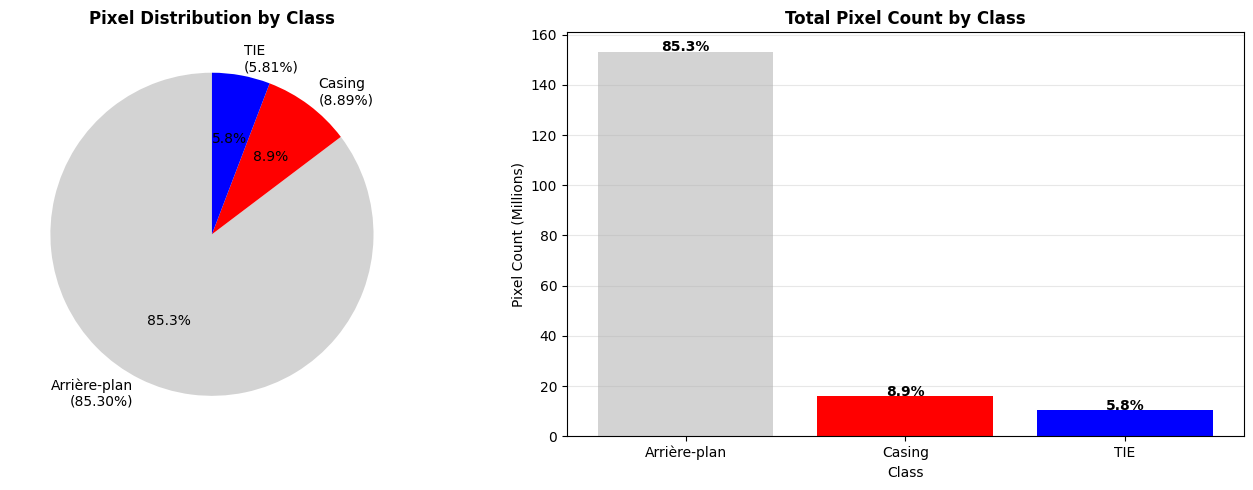

In [10]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Pixel distribution
pixel_percentages = [(class_counts[i] / total_pixels) * 100 for i in [0, 1, 2]]
colors_plot = ['lightgray', 'red', 'blue']
labels_plot = [f'{class_names[i]}\n({pixel_percentages[i]:.2f}%)' for i in range(3)]

axes[0].pie(pixel_percentages, labels=labels_plot, colors=colors_plot, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Pixel Distribution by Class', fontsize=12, fontweight='bold')

# Plot 2: Patch presence distribution
patch_percentages = [(patch_class_presence[i] / total_patches) * 100 for i in [0, 1, 2]]
axes[1].bar(range(3), [class_counts[i] / 1e6 for i in range(3)], color=colors_plot)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Pixel Count (Millions)')
axes[1].set_title('Total Pixel Count by Class', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(3))
axes[1].set_xticklabels([class_names[i] for i in range(3)])
axes[1].grid(axis='y', alpha=0.3)

for i, (count, pct) in enumerate(zip([class_counts[j] / 1e6 for j in range(3)], pixel_percentages)):
    axes[1].text(i, count + 0.1, f'{pct:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

On remarque que l'on a 85% d'arrière plan, 9% de casing, et 6% de TIE, les classes sont très peu balancées, ce qui peut poser un problème durant l'entraînement, surtout que ce sont les classes d'intérêt qui sont minoritaires.
Les solutions à ça sont déjà d'utiliser une métrique adapter (comme l'IOU proposée dans l'explication du datachallenge) et une pondération des classes.

Regardons maintenant plus en détail par puit

In [11]:
# Detailed statistics per well

well_statistics = []

for well in sorted(wells_info.keys(), key=lambda x: int(x)):
    well_patches = [p for p in y_train.index if f'well_{well}_' in p]
    
    # Count pixels per class in this well
    well_class_counts = {0: 0, 1: 0, 2: 0}
    well_patch_class_presence = {0: 0, 1: 0, 2: 0}
    patch_dims = defaultdict(int)
    
    for patch_name in well_patches:
        label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
        num_pixels = len(label_values)
        
        # Count dimension types
        if num_pixels == 160 * 160:
            patch_dims['160x160'] += 1
        elif num_pixels == 160 * 272:
            patch_dims['160x272'] += 1
        
        for class_id in [0, 1, 2]:
            count = np.sum(label_values == class_id)
            well_class_counts[class_id] += count
            if count > 0:
                well_patch_class_presence[class_id] += 1
    
    # Calculate percentages
    total_well_pixels = sum(well_class_counts.values())
    
    well_stat = {
        'Well': well,
        'Patches': len(well_patches),
        'Sections': len(wells_info[well]),
        'Casing %': (well_class_counts[1] / total_well_pixels * 100) if total_well_pixels > 0 else 0,
        'TIE %': (well_class_counts[2] / total_well_pixels * 100) if total_well_pixels > 0 else 0,
        'Dominant Size': max(patch_dims.items(), key=lambda x: x[1])[0] if patch_dims else 'N/A'
    }
    
    well_statistics.append(well_stat)

# Create DataFrame
well_stats_df = pd.DataFrame(well_statistics)
print("=" * 80)
print("DISTRIBUTION POUR CHAQUE PUITS")
print("=" * 80)
print(well_stats_df.to_string(index=False))

print("\n\nObservations clés:")
print(f"  • Puits avec le plus de patchs: Puit {well_stats_df.loc[well_stats_df['Patches'].idxmax(), 'Well']} ({well_stats_df['Patches'].max()} patches)")
print(f"  • Puits avec le moins de patchs: Puit {well_stats_df.loc[well_stats_df['Patches'].idxmin(), 'Well']} ({well_stats_df['Patches'].min()} patches)")
print(f"  • Moyenne de pixels de casing par puit: {well_stats_df['Casing %'].mean():.2f}%")
print(f"  • Moyenne de pixels de TIE par puit: {well_stats_df['TIE %'].mean():.2f}%")

DISTRIBUTION POUR CHAQUE PUITS
Well  Patches  Sections  Casing %     TIE % Dominant Size
   1      666        18  8.708443  5.943534       160x272
   2     1152        36  8.660689  5.181983       160x272
   3      486        18 10.422928 10.596627       160x160
   4      198        18  9.921382  9.052004       160x160
   5      288        18  8.072087  4.386098       160x272
   6     1620        18  8.925692  5.377231       160x272


Observations clés:
  • Puits avec le plus de patchs: Puit 6 (1620 patches)
  • Puits avec le moins de patchs: Puit 4 (198 patches)
  • Moyenne de pixels de casing par puit: 9.12%
  • Moyenne de pixels de TIE par puit: 6.76%


On remarque que la quantité de TIE par puits est assez hétérogène, le puits 3 a plus de deux fois plus de pixels de TIE que le puits 5. On en conclut que probablement les coefficients de pondération des classes seront différents par puits peut-être

## Preprocessing des données
### Standardisation des dimensions d'image

Puisque toutes les images n'ont pas la même dimension, on change cela, comme dans le benchmark pour avoir que des images carrées.
Dans le benchmark, le resizing est fait grâce à torchvision, ici on a préféré utiliser OpenCV car on doit resize une seule fois avant l'entraînement, on a donc pas besoin d'utiliser des transormations de tenseurs, plus difficiles. Qui plus est, OpenCV est plus performant pour du resizing pur.

In [12]:
import sys
from deep_datachallenge.preprocessing import ImagePreprocessor

# Initialiser le preprocessor
preprocessor = ImagePreprocessor(target_size=(160, 160))
print(f"  Target size: {preprocessor.target_size}")

  Target size: (160, 160)


In [13]:
# Charger des exemples d'images avec différentes dimensions
examples_160x160 = []
examples_160x272 = []

for patch_name in y_train.index[:30]:
    image_path = x_train_dir / f"{patch_name}.npy"
    image = np.load(image_path)
    
    label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
    label = label_values.reshape(160, -1)
    
    if image.shape == (160, 160):
        examples_160x160.append((patch_name, image, label))
    elif image.shape == (160, 272):
        examples_160x272.append((patch_name, image, label))

print(f"Exemples trouvés:")
print(f"  • 160x160: {len(examples_160x160)} patches")
print(f"  • 160x272: {len(examples_160x272)} patches")

Exemples trouvés:
  • 160x160: 5 patches
  • 160x272: 25 patches


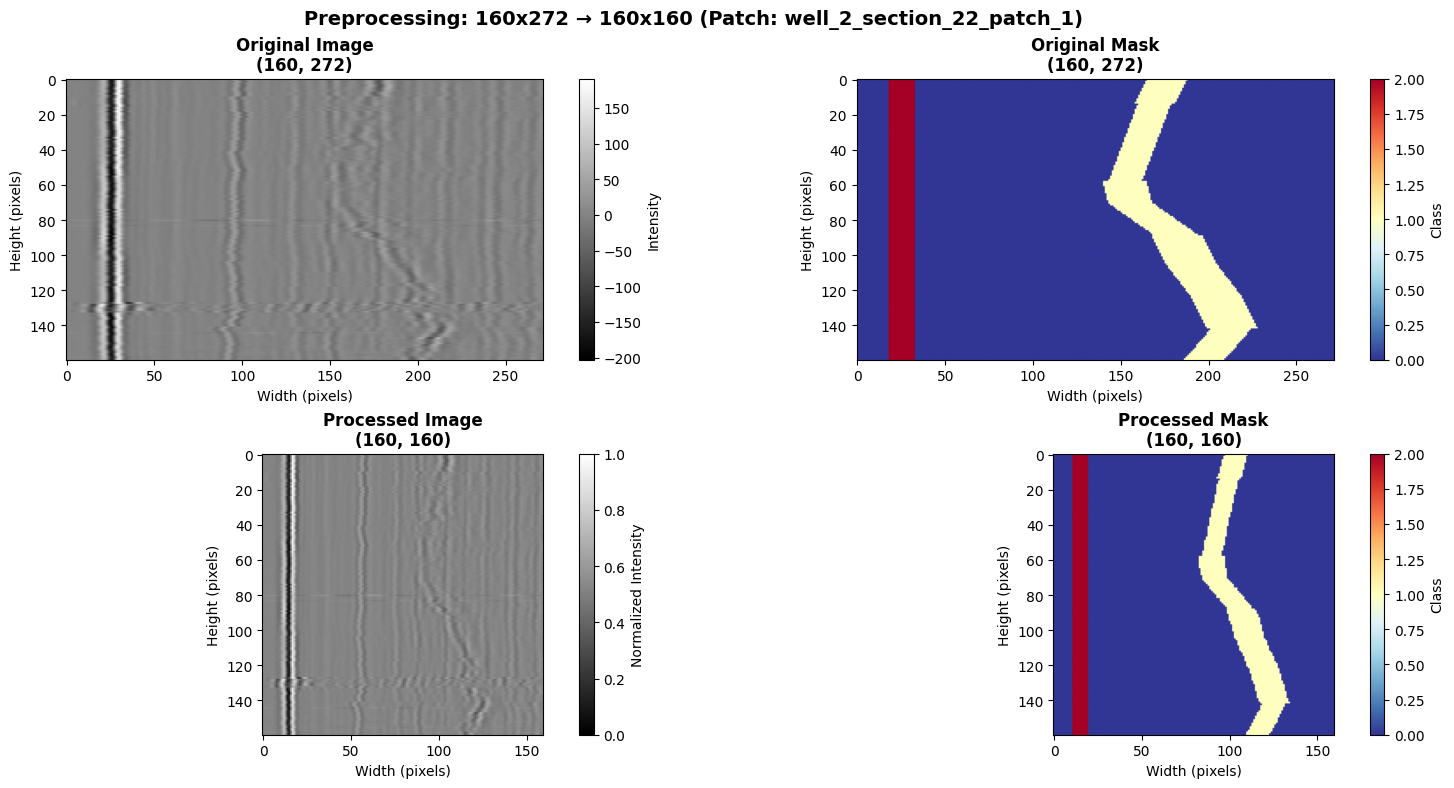

In [14]:
# Afficher le résultat du preprocessing pour une image 160x272
if examples_160x272:
    patch_name, original_image, original_mask = examples_160x272[0]
    
    # Appliquer le preprocessing
    processed_image, processed_mask = preprocessor.full_preprocessing(
        original_image, original_mask, normalize=True
    )
    
    # Visualiser avant/après
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    fig.suptitle(f'Preprocessing: 160x272 → 160x160 (Patch: {patch_name})', 
                 fontsize=14, fontweight='bold')
    
    # Ligne 1: Original (image + mask)
    ax1 = axes[0, 0]
    im1 = ax1.imshow(original_image, cmap='gray')
    ax1.set_title(f'Original Image\n{original_image.shape}', fontweight='bold')
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Height (pixels)')
    plt.colorbar(im1, ax=ax1, label='Intensity')
    
    ax2 = axes[0, 1]
    im2 = ax2.imshow(original_mask, cmap='RdYlBu_r', vmin=0, vmax=2)
    ax2.set_title(f'Original Mask\n{original_mask.shape}', fontweight='bold')
    ax2.set_xlabel('Width (pixels)')
    ax2.set_ylabel('Height (pixels)')
    plt.colorbar(im2, ax=ax2, label='Class')
    
    
    # Ligne 2: Processed (image + mask)
    ax3 = axes[1, 0]
    im3 = ax3.imshow(processed_image, cmap='gray')
    ax3.set_title(f'Processed Image\n{processed_image.shape}', fontweight='bold')
    ax3.set_xlabel('Width (pixels)')
    ax3.set_ylabel('Height (pixels)')
    plt.colorbar(im3, ax=ax3, label='Normalized Intensity')
    
    ax4 = axes[1, 1]
    im4 = ax4.imshow(processed_mask, cmap='RdYlBu_r', vmin=0, vmax=2)
    ax4.set_title(f'Processed Mask\n{processed_mask.shape}', fontweight='bold')
    ax4.set_xlabel('Width (pixels)')
    ax4.set_ylabel('Height (pixels)')
    plt.colorbar(im4, ax=ax4, label='Class')
        
    plt.tight_layout()
    plt.show()

In [15]:
# Vérifier que le preprocessing fonctionne sur tous les types d'images
print("\n" + "=" * 70)
print("TEST SUR TOUS LES TYPES D'IMAGES")
print("=" * 70)

test_results = {
    '160x160': [],
    '160x272': []
}

# Tester sur un échantillon
sample_size = 50
for i, patch_name in enumerate(y_train.index[:sample_size]):
    image_path = x_train_dir / f"{patch_name}.npy"
    image = np.load(image_path)
    
    label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
    mask = label_values.reshape(160, -1)
    
    # Appliquer preprocessing
    proc_image, proc_mask = preprocessor.full_preprocessing(image, mask)
    
    # Vérifier que tout est bien 160x160
    assert proc_image.shape == (160, 160), f"Image shape error: {proc_image.shape}"
    assert proc_mask.shape == (160, 160), f"Mask shape error: {proc_mask.shape}"
    
    original_type = f"{image.shape[0]}x{image.shape[1]}"
    test_results[original_type].append({
        'patch': patch_name,
        'original_shape': image.shape,
        'processed_shape': proc_image.shape,
        'image_normalized': proc_image.min() >= 0 and proc_image.max() <= 1,
        'mask_classes_preserved': set(np.unique(proc_mask)).issubset(set(np.unique(mask)))
    })

# Afficher les résultats
for img_type, results in test_results.items():
    if results:
        print(f"\n{img_type} ({len(results)} images):")
        print(f"Tous les preprocessing réussis")
        print(f"Shapes finales: tous {(160, 160)}")
        
        normalized_ok = all(r['image_normalized'] for r in results)
        print(f"Normalization OK: {normalized_ok}")
        
        classes_ok = all(r['mask_classes_preserved'] for r in results)
        print(f"Classes préservées: {classes_ok}")

print("\n" + "=" * 70)
print("PREPROCESSING VALIDATION: SUCCESS")
print("=" * 70)


TEST SUR TOUS LES TYPES D'IMAGES

160x160 (7 images):
Tous les preprocessing réussis
Shapes finales: tous (160, 160)
Normalization OK: True
Classes préservées: True

160x272 (43 images):
Tous les preprocessing réussis
Shapes finales: tous (160, 160)
Normalization OK: True
Classes préservées: True

PREPROCESSING VALIDATION: SUCCESS


### Gestion des valeurs manquantes (NaN)
Comme pour le benchmark, on peut avoir des NaN qui apparaissent après le resizing, on implémente donc une fonction qui remplace les NaN par des 0 après resizing, voici un test

In [21]:
# Démonstration du remplissage des valeurs manquantes (NaN)
print("\n" + "=" * 70)
print("GESTION DES VALEURS MANQUANTES (NaN)")
print("=" * 70)
print("Note: fill_missing s'active SEULEMENT si des NaN sont détectés après le resize")

# Démonstration 1: Remplissage simple (utilitaire)
test_image_with_nan = np.array([
    [1.0, 2.0, np.nan, 4.0],
    [5.0, np.nan, 7.0, 8.0],
    [9.0, 10.0, 11.0, np.nan],
    [np.nan, 14.0, 15.0, 16.0]
], dtype=np.float32)

print("\nImage de test avec NaN:")
print(test_image_with_nan)
print(f"Nombre de NaN: {np.isnan(test_image_with_nan).sum()}")

image_filled = preprocessor.fill_missing_values(test_image_with_nan, fill_value=0)

print("\nAprès remplissage direct:")
print(image_filled)
print(f"Nombre de NaN: {np.isnan(image_filled).sum()}")


GESTION DES VALEURS MANQUANTES (NaN)
Note: fill_missing s'active SEULEMENT si des NaN sont détectés après le resize

Image de test avec NaN:
[[ 1.  2. nan  4.]
 [ 5. nan  7.  8.]
 [ 9. 10. 11. nan]
 [nan 14. 15. 16.]]
Nombre de NaN: 4

Après remplissage direct:
[[ 1.  2.  0.  4.]
 [ 5.  0.  7.  8.]
 [ 9. 10. 11.  0.]
 [ 0. 14. 15. 16.]]
Nombre de NaN: 0


### Normalisation des images (min-max scaling)
Avant d'utiliser les images dans un réseau de neurones, on normalise les valeurs à la plage [0, 1] en utilisant le scaling min-max par patch


DÉMONSTRATION DE LA NORMALISATION (MIN-MAX SCALING)

Image: well_2_section_22_patch_1
  • Shape: (160, 272)
  • Type: int16

Valeurs AVANT normalisation:
  • Min: -203
  • Max: 191
  • Mean: -0.4477
  • Std: 25.2255

Valeurs APRÈS normalisation (min-max):
  • Min: 0.000000
  • Max: 1.000000
  • Mean: 0.514092
  • Std: 0.064024
  • Type: float32

✓ Toutes les valeurs sont maintenant dans la plage [0, 1]


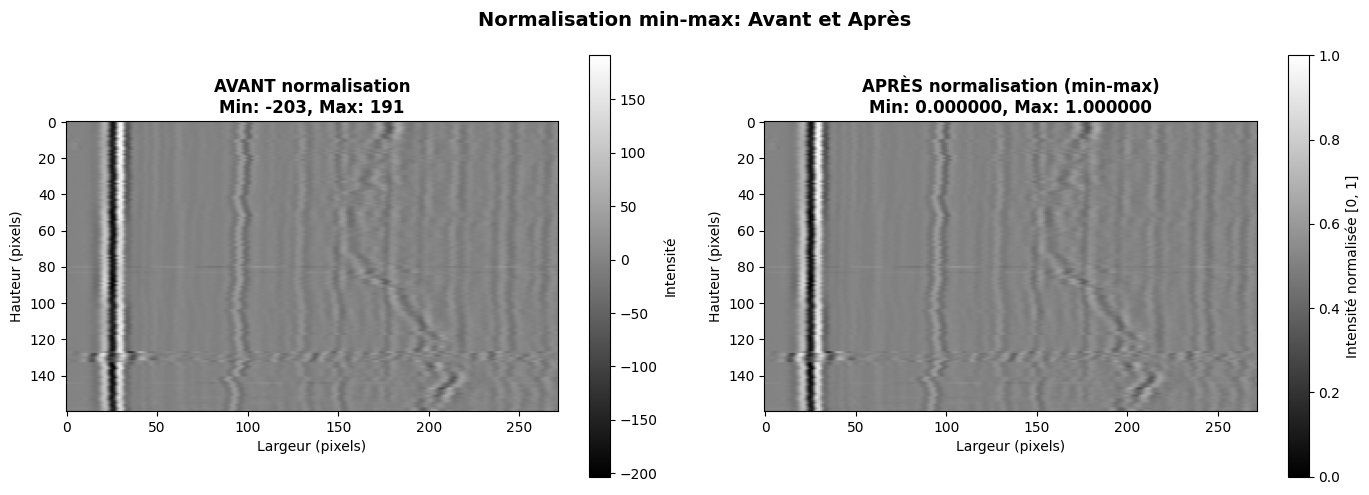

In [23]:
# Démonstration de la normalisation (min-max scaling)
print("\n" + "=" * 70)
print("DÉMONSTRATION DE LA NORMALISATION (MIN-MAX SCALING)")
print("=" * 70)

if examples_160x272:
    patch_name, original_image, original_mask = examples_160x272[0]
    
    print(f"\nImage: {patch_name}")
    print(f"  • Shape: {original_image.shape}")
    print(f"  • Type: {original_image.dtype}")
    print(f"\nValeurs AVANT normalisation:")
    print(f"  • Min: {original_image.min()}")
    print(f"  • Max: {original_image.max()}")
    print(f"  • Mean: {original_image.mean():.4f}")
    print(f"  • Std: {original_image.std():.4f}")
    
    # Normaliser uniquement (sans redimensionner)
    image_normalized = preprocessor.normalize_image(original_image)
    
    print(f"\nValeurs APRÈS normalisation (min-max):")
    print(f"  • Min: {image_normalized.min():.6f}")
    print(f"  • Max: {image_normalized.max():.6f}")
    print(f"  • Mean: {image_normalized.mean():.6f}")
    print(f"  • Std: {image_normalized.std():.6f}")
    print(f"  • Type: {image_normalized.dtype}")
    print(f"\n✓ Toutes les valeurs sont maintenant dans la plage [0, 1]")
    
    # Visualiser avant/après normalisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Normalisation min-max: Avant et Après', fontsize=14, fontweight='bold')
    
    # Avant normalisation
    ax1 = axes[0]
    im1 = ax1.imshow(original_image, cmap='gray')
    ax1.set_title(f'AVANT normalisation\nMin: {original_image.min()}, Max: {original_image.max()}', fontweight='bold')
    ax1.set_xlabel('Largeur (pixels)')
    ax1.set_ylabel('Hauteur (pixels)')
    cbar1 = plt.colorbar(im1, ax=ax1, label='Intensité')
    
    # Après normalisation
    ax2 = axes[1]
    im2 = ax2.imshow(image_normalized, cmap='gray')
    ax2.set_title(f'APRÈS normalisation (min-max)\nMin: {image_normalized.min():.6f}, Max: {image_normalized.max():.6f}', fontweight='bold')
    ax2.set_xlabel('Largeur (pixels)')
    ax2.set_ylabel('Hauteur (pixels)')
    cbar2 = plt.colorbar(im2, ax=ax2, label='Intensité normalisée [0, 1]')
    
    plt.tight_layout()
    plt.show()

### Preprocessing complet


PIPELINE COMPLET: RESIZE + NORMALISATION 

Image: well_2_section_22_patch_1

Étape 1 - Image originale (160x272):
  • Range: [-203, 191]
  • NaN détectés: 0

Étape 2 - Après redimensionnement à 160x160:
  • Shape: (160, 160)
  • Range: [-197.0000, 182.0000]
  • NaN générés: 0

Étape 3 - Remplacement des NaN par 0 (si détectés):
  • Pas de NaN trouvés, étape skippée

Étape 4 - Après normalisation min-max:
  • Shape: (160, 160)
  • Range: [0.000000, 1.000000]
  • Mean: 0.518533
  • Std: 0.064113


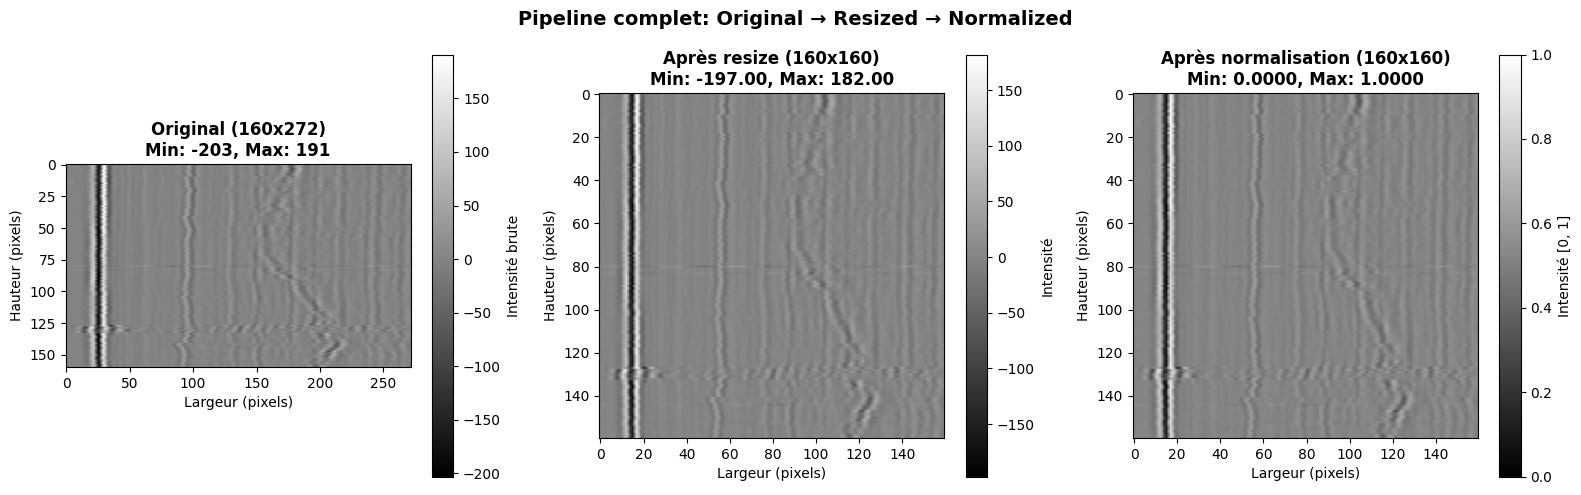

In [27]:
# Démonstration du pipeline complet: redimensionnement + normalisation
print("\n" + "=" * 70)
print("PIPELINE COMPLET: RESIZE + NORMALISATION ")
print("=" * 70)

if examples_160x272:
    patch_name, original_image, original_mask = examples_160x272[0]
    
    # Appliquer le pipeline complet
    image_processed, mask_processed = preprocessor.full_preprocessing(
        original_image, original_mask,
        normalize=True,
        fill_missing=True
    )
    
    print(f"\nImage: {patch_name}")
    print(f"\nÉtape 1 - Image originale (160x272):")
    print(f"  • Range: [{original_image.min()}, {original_image.max()}]")
    print(f"  • NaN détectés: {np.isnan(original_image).sum()}")
    
    print(f"\nÉtape 2 - Après redimensionnement à 160x160:")
    image_resized, _ = preprocessor.preprocess_pair(original_image, original_mask)
    nan_after_resize = np.isnan(image_resized).sum()
    print(f"  • Shape: {image_resized.shape}")
    print(f"  • Range: [{image_resized.min():.4f}, {image_resized.max():.4f}]")
    print(f"  • NaN générés: {nan_after_resize}")
    
    print(f"\nÉtape 3 - Remplacement des NaN par 0 (si détectés):")
    if nan_after_resize > 0:
        image_after_nan_fill = preprocessor.fill_missing_values(image_resized, fill_value=0)
        print(f"  • NaN trouvés: {nan_after_resize}")
        print(f"  • NaN après remplissage: {np.isnan(image_after_nan_fill).sum()}")
        print(f"Tous les NaN ont été remplacés par 0")
    else:
        print(f"  • Pas de NaN trouvés, étape skippée")
        image_after_nan_fill = image_resized.copy()
    
    print(f"\nÉtape 4 - Après normalisation min-max:")
    print(f"  • Shape: {image_processed.shape}")
    print(f"  • Range: [{image_processed.min():.6f}, {image_processed.max():.6f}]")
    print(f"  • Mean: {image_processed.mean():.6f}")
    print(f"  • Std: {image_processed.std():.6f}")
    
    # Visualisation 3 colonnes: original, resized (non-normalisé), processé (normalisé)
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Pipeline complet: Original → Resized → Normalized', fontsize=14, fontweight='bold')
    
    # Original
    ax1 = axes[0]
    im1 = ax1.imshow(original_image, cmap='gray')
    ax1.set_title(f'Original (160x272)\nMin: {original_image.min()}, Max: {original_image.max()}', fontweight='bold')
    ax1.set_xlabel('Largeur (pixels)')
    ax1.set_ylabel('Hauteur (pixels)')
    plt.colorbar(im1, ax=ax1, label='Intensité brute')
    
    # Resized (non-normalisé)
    ax2 = axes[1]
    im2 = ax2.imshow(image_resized, cmap='gray')
    ax2.set_title(f'Après resize (160x160)\nMin: {image_resized.min():.2f}, Max: {image_resized.max():.2f}', fontweight='bold')
    ax2.set_xlabel('Largeur (pixels)')
    ax2.set_ylabel('Hauteur (pixels)')
    plt.colorbar(im2, ax=ax2, label='Intensité')
    
    # Processé (normalisé)
    ax3 = axes[2]
    im3 = ax3.imshow(image_processed, cmap='gray')
    ax3.set_title(f'Après normalisation (160x160)\nMin: {image_processed.min():.4f}, Max: {image_processed.max():.4f}', fontweight='bold')
    ax3.set_xlabel('Largeur (pixels)')
    ax3.set_ylabel('Hauteur (pixels)')
    plt.colorbar(im3, ax=ax3, label='Intensité [0, 1]')
    
    plt.tight_layout()
    plt.show()

## Modèles

Pour le premier modèle, on répète le benchmark pour avoir une base de performances assurée

Pour un second modèle, on s'est penchés sur de la littérature scientifique:
https://ieeexplore.ieee.org/abstract/document/9356353?casa_token=2LGBDIRLZBYAAAAA:M0I3WsesnJe9X-YgQFMml7NrJWc4jl0qKWAvdpL96LmHuDzauaGceeHWKpYt7kL_f0PHaUT7G_x79F8

Dans ce papier, une méthode courante pour la segmentation d'images médicales (peu de données, donc adaptée à ce cas) et le modèle U-net. On implémente donc ce modèle et observe ces résultats.
L'avantage d'un U-Net est que par sa structure (encodeur-décodeur), on force le modèle à trouver une représentation de l'image dans un espace de plus faible dimension, et donc on réduit le nombre de paramètres. 
De plus, ce modèle brille lorsqu'on utilise des petites images, où on cherche juste les frontières.